<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/Low_Rank_Fact_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, I explore low-rank factorisation methods for neural network compression and efficient adaptation. I begin with the mathematical foundation: the Singular Value Decomposition (SVD), which reveals the intrinsic dimensionality of weight matrices. I then implement SVD-based compression, replacing a large weight matrix W with the product of smaller matrices UV^T. The key insight is that neural network weights are often approximately low-rank—we can discard small singular values with minimal accuracy loss. We extend this to tensor decomposition for convolutional layers, then build toward the crown jewel: Low-Rank Adaptation (LoRA), which freezes pretrained weights and learns low-rank update matrices. LoRA has revolutionized LLM fine-tuning by reducing trainable parameters by 10,000x while matching full fine-tuning performance. Our experiments systematically compare compression ratios, accuracy trade-offs, and the surprising effectiveness of low-rank approximations.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List, Dict, Tuple
from copy import deepcopy
from collections import OrderedDict
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
def analyze_matrix_rank(W: torch.Tensor, name: str = "Weight") -> Dict:
    """Analyze the effective rank of a weight matrix."""
    U, S, Vh = torch.linalg.svd(W.float(), full_matrices=False)

    total_energy = (S ** 2).sum().item()
    cumulative_energy = torch.cumsum(S ** 2, dim=0) / total_energy

    thresholds = [0.9, 0.95, 0.99, 0.999]
    effective_ranks = {}
    for thresh in thresholds:
        rank = (cumulative_energy < thresh).sum().item() + 1
        effective_ranks[thresh] = min(rank, len(S))

    stable_rank = total_energy / (S[0] ** 2).item()

    return {
        'name': name,
        'shape': tuple(W.shape),
        'full_rank': min(W.shape),
        'singular_values': S.cpu().numpy(),
        'cumulative_energy': cumulative_energy.cpu().numpy(),
        'effective_ranks': effective_ranks,
        'stable_rank': stable_rank
    }


def visualize_singular_values(analyses: List[Dict]):
    """Visualize singular value distributions."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    for analysis in analyses:
        S = analysis['singular_values']
        ax.semilogy(S / S[0], label=f"{analysis['name']} {analysis['shape']}")
    ax.set_xlabel('Index')
    ax.set_ylabel('Normalized Singular Value (log)')
    ax.set_title('Singular Value Decay')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    for analysis in analyses:
        ax.plot(analysis['cumulative_energy'], label=analysis['name'])
    ax.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% energy')
    ax.axhline(y=0.99, color='orange', linestyle='--', alpha=0.7, label='99% energy')
    ax.set_xlabel('Number of Singular Values')
    ax.set_ylabel('Cumulative Energy')
    ax.set_title('Energy Concentration')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('singular_value_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nEffective Ranks:")
    for analysis in analyses:
        print(f"\n{analysis['name']} {analysis['shape']} (full rank: {analysis['full_rank']})")
        print(f"  Stable rank: {analysis['stable_rank']:.1f}")
        for thresh, rank in analysis['effective_ranks'].items():
            print(f"  {100*thresh:.1f}% energy: rank {rank}")

SVD-Based Compression

In [3]:
class SVDLinear(nn.Module):
    """Linear layer compressed via SVD: W ≈ U @ V^T"""

    def __init__(self, in_features: int, out_features: int, rank: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank

        self.V = nn.Parameter(torch.empty(in_features, rank))
        self.U = nn.Parameter(torch.empty(out_features, rank))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)

        self._init_weights()

    def _init_weights(self):
        nn.init.kaiming_uniform_(self.V, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.U, a=math.sqrt(5))
        scale = math.sqrt(2.0 / (self.in_features + self.out_features))
        self.V.data *= scale / math.sqrt(self.rank)
        self.U.data *= scale / math.sqrt(self.rank)
        if self.bias is not None:
            bound = 1 / math.sqrt(self.in_features)
            nn.init.uniform_(self.bias, -bound, bound)

    @classmethod
    def from_linear(cls, linear: nn.Linear, rank: int) -> 'SVDLinear':
        """Create from existing Linear using SVD."""
        W = linear.weight.data
        U, S, Vh = torch.linalg.svd(W.float(), full_matrices=False)

        r = min(rank, len(S))
        sqrt_S = torch.sqrt(S[:r])
        U_scaled = U[:, :r] * sqrt_S.unsqueeze(0)
        V_scaled = Vh[:r, :].T * sqrt_S.unsqueeze(0)

        layer = cls(linear.in_features, linear.out_features, r, linear.bias is not None)
        layer.U.data = U_scaled.to(linear.weight.dtype)
        layer.V.data = V_scaled.to(linear.weight.dtype)
        if linear.bias is not None:
            layer.bias.data = linear.bias.data.clone()
        return layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = x @ self.V
        y = h @ self.U.T
        if self.bias is not None:
            y = y + self.bias
        return y

    @property
    def compression_ratio(self) -> float:
        original = self.in_features * self.out_features
        compressed = self.rank * (self.in_features + self.out_features)
        return original / compressed

In [4]:
class SVDCompressor:
    """Compress model using SVD on linear layers."""

    def __init__(self, rank_ratio: float = 0.5, min_rank: int = 4,
                 energy_threshold: Optional[float] = None):
        self.rank_ratio = rank_ratio
        self.min_rank = min_rank
        self.energy_threshold = energy_threshold

    def _compute_rank(self, weight: torch.Tensor) -> int:
        full_rank = min(weight.shape)
        if self.energy_threshold is not None:
            _, S, _ = torch.linalg.svd(weight.float(), full_matrices=False)
            total_energy = (S ** 2).sum()
            cumulative = torch.cumsum(S ** 2, dim=0) / total_energy
            rank = (cumulative < self.energy_threshold).sum().item() + 1
        else:
            rank = int(full_rank * self.rank_ratio)
        return max(self.min_rank, min(rank, full_rank))

    def compress_model(self, model: nn.Module) -> Tuple[nn.Module, Dict]:
        """Compress all linear layers."""
        model = deepcopy(model)
        stats = {'layers': {}, 'total_original_params': 0, 'total_compressed_params': 0}

        for name, module in list(model.named_modules()):
            if isinstance(module, nn.Linear):
                parts = name.split('.')
                parent = model
                for part in parts[:-1]:
                    parent = getattr(parent, part)

                rank = self._compute_rank(module.weight.data)
                compressed = SVDLinear.from_linear(module, rank)
                setattr(parent, parts[-1], compressed)

                orig_params = module.weight.numel() + (module.bias.numel() if module.bias is not None else 0)
                comp_params = compressed.U.numel() + compressed.V.numel() + \
                              (compressed.bias.numel() if compressed.bias is not None else 0)

                stats['layers'][name] = {
                    'original_shape': tuple(module.weight.shape),
                    'rank': rank,
                    'compression_ratio': orig_params / comp_params
                }
                stats['total_original_params'] += orig_params
                stats['total_compressed_params'] += comp_params

        stats['overall_compression'] = stats['total_original_params'] / stats['total_compressed_params']
        return model, stats

Tensor Decomposition

In [5]:
class SVDConv2d(nn.Module):
    """Conv2d compressed via SVD decomposition."""

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int,
                 rank: int, stride: int = 1, padding: int = 0, bias: bool = True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.rank = rank

        self.conv1 = nn.Conv2d(in_channels, rank, kernel_size, stride=stride,
                               padding=padding, bias=False)
        self.conv2 = nn.Conv2d(rank, out_channels, 1, stride=1, padding=0, bias=bias)

    @classmethod
    def from_conv2d(cls, conv: nn.Conv2d, rank: int) -> 'SVDConv2d':
        W = conv.weight.data
        out_ch, in_ch, k1, k2 = W.shape

        W_mat = W.reshape(out_ch, -1)
        U, S, Vh = torch.linalg.svd(W_mat.float(), full_matrices=False)

        r = min(rank, len(S))
        sqrt_S = torch.sqrt(S[:r])
        U_r = U[:, :r] * sqrt_S.unsqueeze(0)
        V_r = Vh[:r, :].T * sqrt_S.unsqueeze(0)

        V_conv = V_r.T.reshape(r, in_ch, k1, k2)
        U_conv = U_r.unsqueeze(-1).unsqueeze(-1)

        layer = cls(in_ch, out_ch, k1, r, conv.stride[0], conv.padding[0], conv.bias is not None)
        layer.conv1.weight.data = V_conv.to(conv.weight.dtype)
        layer.conv2.weight.data = U_conv.to(conv.weight.dtype)
        if conv.bias is not None:
            layer.conv2.bias.data = conv.bias.data.clone()
        return layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv2(self.conv1(x))

    @property
    def compression_ratio(self) -> float:
        original = self.out_channels * self.in_channels * self.kernel_size ** 2
        compressed = self.rank * self.in_channels * self.kernel_size ** 2 + self.out_channels * self.rank
        return original / compressed

Low Rank Adaptation (LORA)

In [6]:
class LoRALinear(nn.Module):
    """Linear layer with Low-Rank Adaptation."""

    def __init__(self, in_features: int, out_features: int, rank: int = 4,
                 alpha: float = 1.0, dropout: float = 0.0, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank

        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)

        self.lora_A = nn.Parameter(torch.empty(rank, in_features))
        self.lora_B = nn.Parameter(torch.empty(out_features, rank))
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        self._init_weights()
        self.weight.requires_grad = False
        if self.bias is not None:
            self.bias.requires_grad = False

    def _init_weights(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn.init.uniform_(self.bias, -1/math.sqrt(self.in_features), 1/math.sqrt(self.in_features))
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    @classmethod
    def from_linear(cls, linear: nn.Linear, rank: int = 4, alpha: float = 1.0,
                    dropout: float = 0.0) -> 'LoRALinear':
        layer = cls(linear.in_features, linear.out_features, rank, alpha, dropout,
                    linear.bias is not None)
        layer.weight.data = linear.weight.data.clone()
        if linear.bias is not None:
            layer.bias.data = linear.bias.data.clone()
        return layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = F.linear(x, self.weight, self.bias)
        lora_out = self.dropout(x) @ self.lora_A.T @ self.lora_B.T * self.scaling
        return result + lora_out

    def merge_weights(self) -> nn.Linear:
        """Merge LoRA into base weights."""
        merged = nn.Linear(self.in_features, self.out_features, self.bias is not None)
        merged.weight.data = self.weight.data + self.scaling * (self.lora_B @ self.lora_A)
        if self.bias is not None:
            merged.bias.data = self.bias.data.clone()
        return merged

    @property
    def num_trainable_params(self) -> int:
        return self.rank * (self.in_features + self.out_features)

In [7]:
class LoRAModel(nn.Module):
    """Wrapper to add LoRA to model layers."""

    def __init__(self, model: nn.Module, rank: int = 4, alpha: float = 1.0,
                 target_modules: Optional[List[str]] = None, dropout: float = 0.0):
        super().__init__()
        self.model = deepcopy(model)
        self.rank = rank
        self.alpha = alpha
        self.target_modules = target_modules

        self._apply_lora(rank, alpha, dropout)
        self._freeze_base()

    def _apply_lora(self, rank: int, alpha: float, dropout: float):
        for name, module in list(self.model.named_modules()):
            if not isinstance(module, nn.Linear):
                continue
            if self.target_modules and not any(t in name for t in self.target_modules):
                continue

            parts = name.split('.')
            parent = self.model
            for part in parts[:-1]:
                parent = getattr(parent, part)
            setattr(parent, parts[-1], LoRALinear.from_linear(module, rank, alpha, dropout))

    def _freeze_base(self):
        for name, param in self.model.named_parameters():
            if 'lora_' not in name:
                param.requires_grad = False

    def forward(self, x):
        return self.model(x)

    def get_lora_parameters(self) -> List[nn.Parameter]:
        return [p for n, p in self.model.named_parameters() if 'lora_' in n]

    def get_trainable_parameters(self) -> List[nn.Parameter]:
        return [p for p in self.model.parameters() if p.requires_grad]

    def merge_and_unload(self) -> nn.Module:
        model = deepcopy(self.model)
        for name, module in list(model.named_modules()):
            if isinstance(module, LoRALinear):
                parts = name.split('.')
                parent = model
                for part in parts[:-1]:
                    parent = getattr(parent, part)
                setattr(parent, parts[-1], module.merge_weights())
        return model

    def print_trainable_parameters(self):
        trainable = sum(p.numel() for p in self.get_trainable_parameters())
        total = sum(p.numel() for p in self.model.parameters())
        print(f"Trainable: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")

Adapter Methods

In [8]:
class Adapter(nn.Module):
    """Bottleneck adapter module."""

    def __init__(self, input_dim: int, bottleneck_dim: int, nonlinearity: str = 'relu'):
        super().__init__()
        self.down_proj = nn.Linear(input_dim, bottleneck_dim)
        self.up_proj = nn.Linear(bottleneck_dim, input_dim)
        self.act = nn.ReLU() if nonlinearity == 'relu' else nn.GELU() if nonlinearity == 'gelu' else nn.Identity()
        nn.init.zeros_(self.up_proj.weight)
        nn.init.zeros_(self.up_proj.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.up_proj(self.act(self.down_proj(x)))

Experimental Comparisons

In [9]:
class TestMLP(nn.Module):
    def __init__(self, hidden_dims: List[int] = [512, 256, 128]):
        super().__init__()
        layers = []
        prev_dim = 784
        for i, dim in enumerate(hidden_dims):
            layers.append((f'fc{i+1}', nn.Linear(prev_dim, dim)))
            layers.append((f'relu{i+1}', nn.ReLU()))
            prev_dim = dim
        layers.append(('fc_out', nn.Linear(prev_dim, 10)))
        self.layers = nn.Sequential(OrderedDict(layers))
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x.view(x.size(0), -1))


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 508kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]

Train: 60000, Test: 10000


In [10]:
def train_model(model, train_loader, epochs=5, lr=0.001, params=None):
    if params is None:
        params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
            correct += output.argmax(1).eq(target).sum().item()
            total += data.size(0)
        print(f"Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={100*correct/total:.2f}%")
    return model

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            correct += model(data).argmax(1).eq(target).sum().item()
            total += data.size(0)
    return correct / total

In [12]:
print("=" * 70)
print("TRAINING BASELINE MODEL")
print("=" * 70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = TestMLP().to(device)
baseline_model = train_model(baseline_model, train_loader, epochs=5)
baseline_acc = evaluate(baseline_model, test_loader)
baseline_params = sum(p.numel() for p in baseline_model.parameters())
print(f"\nBaseline: {100*baseline_acc:.2f}%, {baseline_params:,} params")
baseline_state = deepcopy(baseline_model.state_dict())

TRAINING BASELINE MODEL
Epoch 1: Loss=0.2146, Acc=93.42%
Epoch 2: Loss=0.0854, Acc=97.33%
Epoch 3: Loss=0.0591, Acc=98.15%
Epoch 4: Loss=0.0490, Acc=98.45%
Epoch 5: Loss=0.0343, Acc=98.85%

Baseline: 98.04%, 567,434 params



EXPERIMENT 1: Weight Matrix Rank Analysis


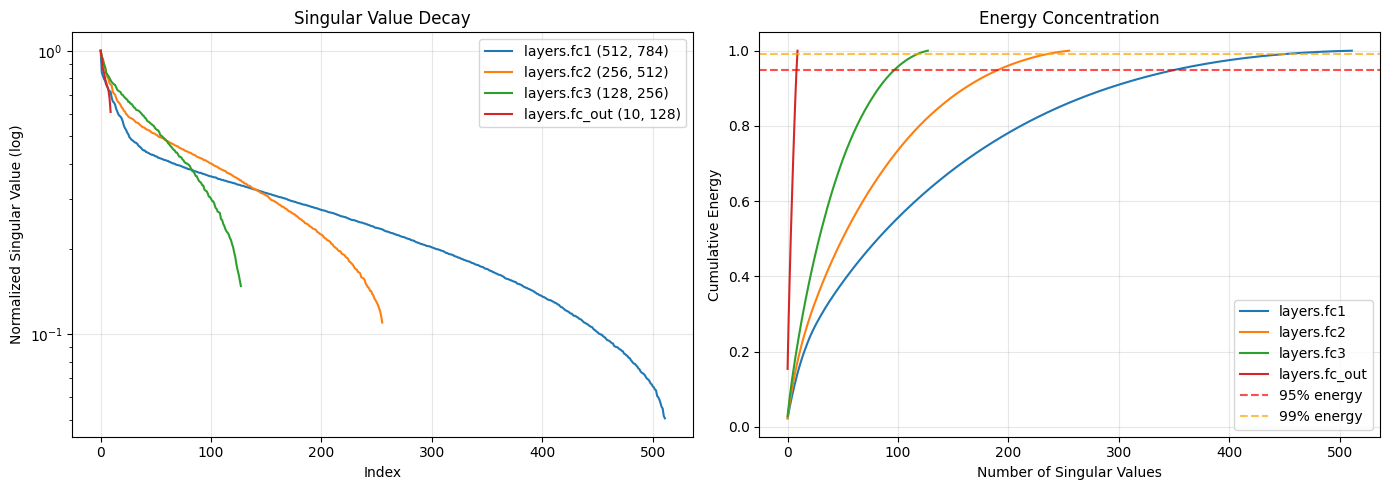


Effective Ranks:

layers.fc1 (512, 784) (full rank: 512)
  Stable rank: 44.3
  90.0% energy: rank 291
  95.0% energy: rank 354
  99.0% energy: rank 447
  99.9% energy: rank 500

layers.fc2 (256, 512) (full rank: 256)
  Stable rank: 43.2
  90.0% energy: rank 162
  95.0% energy: rank 193
  99.0% energy: rank 235
  99.9% energy: rank 253

layers.fc3 (128, 256) (full rank: 128)
  Stable rank: 34.8
  90.0% energy: rank 84
  95.0% energy: rank 99
  99.0% energy: rank 118
  99.9% energy: rank 127

layers.fc_out (10, 128) (full rank: 10)
  Stable rank: 6.5
  90.0% energy: rank 9
  95.0% energy: rank 10
  99.0% energy: rank 10
  99.9% energy: rank 10


In [13]:
print("\n" + "=" * 70)
print("EXPERIMENT 1: Weight Matrix Rank Analysis")
print("=" * 70)

analyses = [analyze_matrix_rank(m.weight.data, n)
            for n, m in baseline_model.named_modules() if isinstance(m, nn.Linear)]
visualize_singular_values(analyses)

In [14]:
print("\n" + "=" * 70)
print("EXPERIMENT 2: SVD Compression")
print("=" * 70)

svd_results = {}
for ratio in [0.1, 0.25, 0.5, 0.75]:
    print(f"\nRank ratio: {ratio}")
    model = TestMLP().to(device)
    model.load_state_dict(deepcopy(baseline_state))

    compressed_model, stats = SVDCompressor(rank_ratio=ratio).compress_model(model)
    compressed_model = compressed_model.to(device)

    acc_no_ft = evaluate(compressed_model, test_loader)
    compressed_model = train_model(compressed_model, train_loader, epochs=3, lr=0.0005)
    acc_ft = evaluate(compressed_model, test_loader)

    svd_results[ratio] = {'compression': stats['overall_compression'], 'acc_no_ft': acc_no_ft, 'acc_ft': acc_ft}
    print(f"  {stats['overall_compression']:.2f}x compression, No FT: {100*acc_no_ft:.2f}%, FT: {100*acc_ft:.2f}%")


EXPERIMENT 2: SVD Compression

Rank ratio: 0.1
Epoch 1: Loss=0.1258, Acc=96.49%
Epoch 2: Loss=0.0556, Acc=98.48%
Epoch 3: Loss=0.0388, Acc=98.86%
  6.21x compression, No FT: 68.60%, FT: 97.82%

Rank ratio: 0.25
Epoch 1: Loss=0.0946, Acc=97.29%
Epoch 2: Loss=0.0417, Acc=98.81%
Epoch 3: Loss=0.0284, Acc=99.15%
  2.48x compression, No FT: 73.39%, FT: 97.54%

Rank ratio: 0.5
Epoch 1: Loss=0.0608, Acc=98.22%
Epoch 2: Loss=0.0317, Acc=99.03%
Epoch 3: Loss=0.0273, Acc=99.16%
  1.24x compression, No FT: 88.53%, FT: 97.93%

Rank ratio: 0.75
Epoch 1: Loss=0.0479, Acc=98.54%
Epoch 2: Loss=0.0311, Acc=98.97%
Epoch 3: Loss=0.0287, Acc=99.09%
  0.83x compression, No FT: 96.18%, FT: 97.98%


In [15]:
print("\n" + "=" * 70)
print("EXPERIMENT 3: LoRA Fine-Tuning")
print("=" * 70)

# Split data for transfer learning simulation
train_idx_pre = [i for i in range(len(train_dataset)) if train_dataset[i][1] < 5]
train_idx_ft = [i for i in range(len(train_dataset)) if train_dataset[i][1] >= 5]
test_idx = [i for i in range(len(test_dataset)) if test_dataset[i][1] >= 5]

pretrain_loader = DataLoader(Subset(train_dataset, train_idx_pre), batch_size=128, shuffle=True)
finetune_loader = DataLoader(Subset(train_dataset, train_idx_ft), batch_size=128, shuffle=True)
finetune_test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=1000)

print(f"Pretrain: {len(train_idx_pre)}, Finetune: {len(train_idx_ft)}")

# Pretrain
print("\nPretraining on digits 0-4...")
pretrain_model = TestMLP().to(device)
pretrain_model = train_model(pretrain_model, pretrain_loader, epochs=5)
pretrain_acc = evaluate(pretrain_model, finetune_test_loader)
print(f"Pretrained accuracy on 5-9: {100*pretrain_acc:.2f}%")
pretrain_state = deepcopy(pretrain_model.state_dict())


EXPERIMENT 3: LoRA Fine-Tuning
Pretrain: 30596, Finetune: 29404

Pretraining on digits 0-4...
Epoch 1: Loss=0.1016, Acc=96.93%
Epoch 2: Loss=0.0341, Acc=98.94%
Epoch 3: Loss=0.0209, Acc=99.33%
Epoch 4: Loss=0.0284, Acc=99.11%
Epoch 5: Loss=0.0102, Acc=99.67%
Pretrained accuracy on 5-9: 0.00%


In [16]:
# Full fine-tuning vs LoRA
print("\nFull fine-tuning...")
full_ft_model = TestMLP().to(device)
full_ft_model.load_state_dict(deepcopy(pretrain_state))
full_ft_model = train_model(full_ft_model, finetune_loader, epochs=5)
full_ft_acc = evaluate(full_ft_model, finetune_test_loader)
full_ft_params = sum(p.numel() for p in full_ft_model.parameters())
print(f"Full FT: {100*full_ft_acc:.2f}%, {full_ft_params:,} trainable")

lora_results = {}
for rank in [1, 4, 16, 64]:
    print(f"\nLoRA rank={rank}...")
    base = TestMLP().to(device)
    base.load_state_dict(deepcopy(pretrain_state))
    lora_model = LoRAModel(base, rank=rank, alpha=rank).to(device)
    lora_model.print_trainable_parameters()

    optimizer = torch.optim.Adam(lora_model.get_trainable_parameters(), lr=0.01)
    for _ in range(5):
        lora_model.train()
        for data, target in finetune_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            F.cross_entropy(lora_model(data), target).backward()
            optimizer.step()

    lora_acc = evaluate(lora_model, finetune_test_loader)
    trainable = sum(p.numel() for p in lora_model.get_trainable_parameters())
    lora_results[rank] = {'accuracy': lora_acc, 'trainable': trainable, 'ratio': trainable/full_ft_params}
    print(f"  Accuracy: {100*lora_acc:.2f}%, Trainable: {trainable:,} ({100*trainable/full_ft_params:.2f}%)")


Full fine-tuning...
Epoch 1: Loss=0.3839, Acc=91.12%
Epoch 2: Loss=0.0539, Acc=98.27%
Epoch 3: Loss=0.0313, Acc=99.06%
Epoch 4: Loss=0.0223, Acc=99.31%
Epoch 5: Loss=0.0165, Acc=99.44%
Full FT: 97.63%, 567,434 trainable

LoRA rank=1...
Trainable: 2,586 / 570,020 (0.45%)
  Accuracy: 94.80%, Trainable: 2,586 (0.46%)

LoRA rank=4...
Trainable: 10,344 / 577,778 (1.79%)
  Accuracy: 96.34%, Trainable: 10,344 (1.82%)

LoRA rank=16...
Trainable: 41,376 / 608,810 (6.80%)
  Accuracy: 0.00%, Trainable: 41,376 (7.29%)

LoRA rank=64...
Trainable: 165,504 / 732,938 (22.58%)
  Accuracy: 21.15%, Trainable: 165,504 (29.17%)


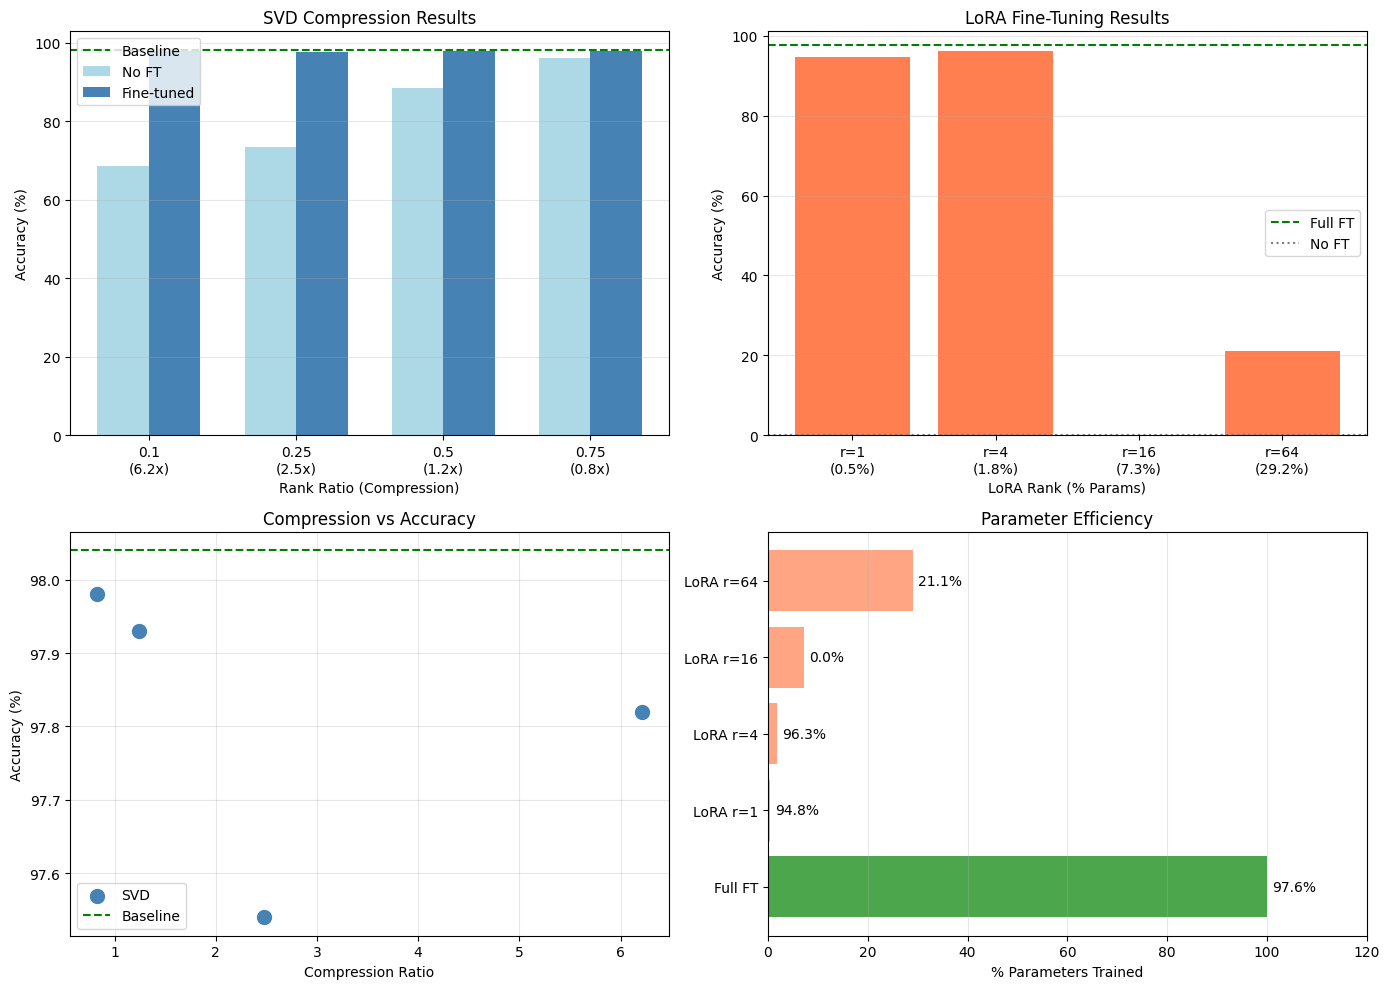

In [17]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# SVD results
ax = axes[0, 0]
ratios = list(svd_results.keys())
x = np.arange(len(ratios))
ax.bar(x - 0.175, [svd_results[r]['acc_no_ft']*100 for r in ratios], 0.35, label='No FT', color='lightblue')
ax.bar(x + 0.175, [svd_results[r]['acc_ft']*100 for r in ratios], 0.35, label='Fine-tuned', color='steelblue')
ax.axhline(baseline_acc*100, color='green', linestyle='--', label='Baseline')
ax.set_xticks(x)
ax.set_xticklabels([f"{r}\n({svd_results[r]['compression']:.1f}x)" for r in ratios])
ax.set_xlabel('Rank Ratio (Compression)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('SVD Compression Results')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# LoRA results
ax = axes[0, 1]
ranks = list(lora_results.keys())
ax.bar(range(len(ranks)), [lora_results[r]['accuracy']*100 for r in ranks], color='coral')
ax.axhline(full_ft_acc*100, color='green', linestyle='--', label='Full FT')
ax.axhline(pretrain_acc*100, color='gray', linestyle=':', label='No FT')
ax.set_xticks(range(len(ranks)))
ax.set_xticklabels([f"r={r}\n({100*lora_results[r]['ratio']:.1f}%)" for r in ranks])
ax.set_xlabel('LoRA Rank (% Params)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('LoRA Fine-Tuning Results')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Compression vs Accuracy
ax = axes[1, 0]
ax.scatter([svd_results[r]['compression'] for r in ratios],
           [svd_results[r]['acc_ft']*100 for r in ratios], s=100, marker='o', label='SVD', c='steelblue')
ax.axhline(baseline_acc*100, color='green', linestyle='--', label='Baseline')
ax.set_xlabel('Compression Ratio')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Compression vs Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# Parameter efficiency
ax = axes[1, 1]
methods = ['Full FT'] + [f'LoRA r={r}' for r in ranks]
params = [100] + [lora_results[r]['ratio']*100 for r in ranks]
accs = [full_ft_acc*100] + [lora_results[r]['accuracy']*100 for r in ranks]
colors = ['green'] + ['coral']*len(ranks)
ax.barh(methods, params, color=colors, alpha=0.7)
for i, (p, a) in enumerate(zip(params, accs)):
    ax.text(p + 1, i, f'{a:.1f}%', va='center')
ax.set_xlabel('% Parameters Trained')
ax.set_title('Parameter Efficiency')
ax.set_xlim(0, 120)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('low_rank_results.png', dpi=150, bbox_inches='tight')
plt.show()